# 多轮问询策略

In [1]:
import pandas as pd
import faiss # Faiss是一个用于高效相似性搜索和聚类的库，这里注释掉了，可能后续用到。
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image # 用于处理图片
import pickle # 用于序列化和反序列化数据
from tqdm import tqdm # 用于显示循环进度条
import matplotlib.pyplot as plt
import random
import os
from openai import OpenAI

import base64
import requests

import json
import re # 正则表达式库，用于文本匹配

## 函数定义

In [2]:
# 设置显示图片的布局
def show_image(image_paths, sentence=None):

    """
    函数用于展示图片。图片将以5列的方式展示，并根据图片路径生成标题。
    参数:
        - image_paths: 图片路径列表。
        - sentence: 可选参数，作为整个图片组的标题显示。
    """
    k=(len(image_paths)+4)//5 # 计算行数
    fig, axs = plt.subplots(nrows=k, ncols=5, figsize=(20, 8))  # 根据需要调整行列数和尺寸
    axs = axs.flatten()  # 将多维数组展平以方便迭代

    # 循环遍历每个图片路径，加载并显示图片
    for ax, img_path in zip(axs, image_paths):
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')  # 不显示坐标轴
            ax.set_title(img_path.split('/')[-1])  # 设置标题为文件名
        except FileNotFoundError:
            ax.imshow(np.zeros((10, 10, 3), dtype=int))  # 如果文件不存在，显示一个黑色方块
            ax.axis('off')
            ax.set_title('File Not Found')
    if sentence:
        fig.suptitle(sentence, fontsize=16)
    plt.tight_layout()
    plt.show()


#图片搜索
class ImageEmbedder:
    def __init__(self, model, preprocessor):
        """ model projects image to vector, processor load and prepare image to the model"""
        self.model = model
        self.processor = preprocessor

def BLIP_BASELINE():
    from torchvision import transforms
    from torchvision.transforms.functional import InterpolationMode

    import sys
    sys.path.insert(0, './BLIP')
    from BLIP.models.blip_itm import blip_itm
    # load model
    model = blip_itm(pretrained='./BLIP/chatir_weights.ckpt',  # Download from Google Drive, see README.md
                     med_config='BLIP/configs/med_config.json',
                     image_size=224,
                     vit='base'
                     )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device).eval()

    # define Image Embedder (raw_image --> img_feature)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

    def blip_project_img(image):
        embeds = model.visual_encoder(image)
        projection = model.vision_proj(embeds[:, 0, :])
        return F.normalize(projection, dim=-1)

    def blip_prep_image(path):
        raw = Image.open(path).convert('RGB')
        return transform_test(raw)

    image_embedder = ImageEmbedder(blip_project_img, lambda path: blip_prep_image(path))

    # define dialog encoder (dialog --> img_feature)
    def dialog_encoder(dialog):
        text = model.tokenizer(dialog, padding='longest', truncation=True,
                               max_length=200,
                               return_tensors="pt"
                               ).to(device)

        text_output = model.text_encoder(text.input_ids, attention_mask=text.attention_mask,
                                         return_dict=True, mode='text')

        shift = model.text_proj(text_output.last_hidden_state[:, 0, :])
        return F.normalize(shift, dim=-1)

    return dialog_encoder, image_embedder

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts: list):
        """
        Args:
            texts (list of str): List of text strings.
            processor (transformers processor): Processor to tokenize the text.
        """
        self.texts = texts
        # self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]  # Get the text at the provided index
        return {'text': text}

def encode_text(dataset, model):
    """CLIP for encode text """
    # model.eval()
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=20,
                                              pin_memory=True,
                                              num_workers=1,
                                              prefetch_factor=2,
                                              shuffle=False,
                                              # collate_fn=data_collector
                                              )
    all_features = []
    with torch.no_grad():
        for batch in data_loader:
            features = model(batch['text'])
            all_features.append(features.cpu())  # 将特征移动到 CPU 并保存
    return torch.cat(all_features)  # 合并所有特征为一个 Tensor


# 这个是处理 group .... dataset的
def retrieve_topk_images(query: list,
                         topk=10,
                         faiss_model=None,
                         blip_model=None,
                         id2image=None,
                         processor=None, ):
    text_dataset = TextDataset(query)
    query_vec = encode_text(text_dataset, blip_model)
    query_vec = query_vec.numpy()
    query_vec /= np.linalg.norm(query_vec, axis=1, keepdims=True)
    # print(f"faiss_model vector dimension (d): {faiss_model.d}")
    # print(f"Query vector dimension: {query_vec.shape}")

    distance, indices = faiss_model.search(query_vec, topk)
    # print(f"Indices returned by faiss_model: {indices[:10]}")  # 只打印前 10 个
    indices = np.array(indices)
    image_paths = [[id2image.get(idx, 'path/not/found') for idx in row] for row in indices]
    
    # 打印对应的 image_paths
    # print(f"Image paths for first 100 indices: {image_paths[0][:100]}")
    return image_paths, indices


# 找出目标ｔａｒｇｅｔ排名
def find_index_in_list(element, my_list):
    return my_list.index(element) 




### 生成 blip_faiss.index, id2image.pickle, blip_image_embedding.pickle

In [3]:
import json
class ImageDataset(torch.utils.data.Dataset):
    """ Dataset class for the corpus images (the 50k potential candidates)"""
    def __init__(self, image_paths, preprocessor):
        self.image_paths = image_paths
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self.preprocessor(image_path)  # Load and prepare image
        return {'id': idx, 'image': image}

In [4]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def encode_images(dataset, image_embedder):
    # model.eval()
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=500,
                                             shuffle=False,
                                             num_workers=2,
                                             pin_memory=True,
                                             drop_last=False,
                                             prefetch_factor=2
                                             )
    print("Preparing corpus (search space)...")
    corpus_vectors = []
    # corpus_ids = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch_vectors = F.normalize(image_embedder.model(batch['image'].to(device)), dim=-1)
            corpus_vectors.append(batch_vectors)
            # corpus_ids.append(batch['id'].to(device))

        corpus_vectors = torch.cat(corpus_vectors)
    return corpus_vectors

In [5]:
# 初始化 BLIP_FT 处理器和模型
dialog_encoder, image_embedder = BLIP_BASELINE()
# 加载图片路径
image_fold = './playground/data/flickr30k-images'
image_paths = os.listdir(image_fold)#[:20]
merge_image_path = [os.path.join(image_fold, p) for p in image_paths]
merge_image_path = sorted(merge_image_path)
id2image = dict(zip(range(len(merge_image_path)), merge_image_path))
with open('./checkpoints/id2image_flickr30k_BLIP_FT.pickle', 'wb') as f:
    pickle.dump(id2image, f)

dataset = ImageDataset(merge_image_path, image_embedder.processor)
# 编码图片
encoded_images = encode_images(dataset, image_embedder)

/root/anaconda3/envs/new_questionIR/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load checkpoint from ./BLIP/chatir_weights.ckpt
Preparing corpus (search space)...


100%|██████████| 64/64 [01:26<00:00,  1.34s/it]


In [6]:
encoded_images.shape

torch.Size([31783, 256])

In [7]:
encoded_images = encoded_images.cpu().numpy()
encoded_images /= np.linalg.norm(encoded_images, axis=1, keepdims=True) 

# 创建 Faiss 索引
dimension = encoded_images.shape[1]
faiss_index = faiss.IndexFlatIP(dimension) # 
faiss_index.add(encoded_images)
faiss.write_index(faiss_index,'./checkpoints/blip_faiss_flickr30k_BLIP_FT.index')

In [8]:
with open('checkpoints/blip_image_embedding_flickr30k_BLIP_FT.pickle', 'wb') as f:
    pickle.dump(encoded_images, f)

In [9]:
# 新添加的
# 添加问题生成的防错机制
def generate_valid_question(base64_image_top, system_prompt, previous_questions, max_retries=5):
    """
    尝试生成问题并确保返回的结果是有效的 JSON 且包含必要的字段。如果遇到问题，则重试。
    """
    for attempt in range(max_retries):
        try:
            # print(f"Attempt {attempt + 1} to generate a valid question.")

            # 调用生成问题的函数
            question_fewshot = question_attribute(base64_image_top, system_prompt, previous_questions)

            # 使用正则表达式提取JSON内容
            question_fewshot_json = extract_json(question_fewshot)

            if question_fewshot_json:
                question_fewshot_json = json.loads(question_fewshot_json)  # 将提取的JSON转换为Python字典
                if "Question to differentiate the pictures" in question_fewshot_json:
                    return question_fewshot_json["Question to differentiate the pictures"]
                else:
                    print(f"Key 'Question to differentiate the pictures' not found, retrying...")

        except json.JSONDecodeError:
            print("JSONDecodeError: The result is not valid JSON, retrying...")
        except KeyError:
            print("KeyError: Expected key not found in the generated JSON, retrying...")
        except Exception as e:
            print(f"An unexpected error occurred: {e}, retrying...")
        
        # 每次循环后 attempt 自动递增
        attempt += 1


    print("Failed to generate a valid question after multiple attempts.")
    return None


In [10]:
def extract_json(text):
    pattern = r'{.*}'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group()
    else:
        return 'parse incorrectly'

In [11]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [12]:
#回答
def answer(question,base64_target_image):
    client = OpenAI(api_key='sk-44zqPIuBStA5LXlG27167746Af504e1d95Fa163fCfEfEd31',base_url = "https://oneapi.offer-ai.net/v1") #国内服务器用
    #原key: sk-proj-ayeOkR2zjMQRbUOt6AytT3BlbkFJDMvIhbZZ7wH93C9l5MPV
    response = client.chat.completions.create(
      model="wxc_paper",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"according to the image, answer the question:{question}，Your answer must be direct and simple",
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_target_image}",
              },
            }
          ],
        }
      ],
      max_tokens=100,
    )
    return response.choices[0].message.content

In [13]:
system_prompt = """
You are an assistant that helps users to differentiate between images by generating specific, non-repetitive questions based on given images. 
Given 5 pictures and a list of questions you have previously asked, your task is to find common objects that appear in all 5 pictures but have distinguishing features. Based on these objects, ask a question that is not included in [previous questions] to differentiate the pictures.
Make sure the question is specific, directly related to the images, and not abstract. Avoid repeating the same attributes mentioned in any previous questions. And don't ask two questions at the same time, such as 'What is the attribute of a or b?'.


For example:
Example 1: All 5 pictures have people, but the number of people differs. You can ask about the number of people.
Example 2: All 5 pictures have cats, but the colors are different. You can ask about the color.
Example 3: All 5 pictures have traffic lights, but their positions differ. You can ask about the position of the traffic lights.


ensure that the output strictly(have to !) follows this JSON format:
{
"What is the common object that appears in all five pictures":"Answer1",
"What is the distinguishing feature that can help differentiate the picture":"Answer2",
"Question to differentiate the pictures":"Answer3"
}
The output should not contain any extra characters or text outside of this JSON structure.

"""

In [14]:
def question_attribute(base64_image_list, system_prompt, previous_questions):
    client = OpenAI(api_key='sk-44zqPIuBStA5LXlG27167746Af504e1d95Fa163fCfEfEd31', base_url="https://oneapi.offer-ai.net/v1")  # 国内服务器用

    # 将之前提问过的问题合并到描述中
    previous_questions_text = " ".join([f'Previous Question: {q}' for q in previous_questions])
    # print("Previous_Question:",previous_questions)
    
    user_prompt = f"""
    [Previous questions]: {previous_questions_text}.
    """
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_prompt}]},  # 设定系统角色
        {"role": "user","content": [{"type": "text", "text": user_prompt}]},  # 用户提问部分
      ]
        # 添加图片内容
    for img_base64 in base64_image_list:
        messages.append({
            "role": "user",
            "content": [{
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}
            }]
        })
    # print("System Prompt:", system_prompt)
    # print("User Prompt", user_prompt)
    # 调用 OpenAI API
    response = client.chat.completions.create(
      model="wxc_paper",
      messages=messages,
      max_tokens=500,
    )
    
    return response.choices[0].message.content


In [15]:
#总结
def summary(query,question,answer):
    client = OpenAI(api_key='sk-44zqPIuBStA5LXlG27167746Af504e1d95Fa163fCfEfEd31',base_url = "https://oneapi.offer-ai.net/v1") #国内服务器用
    #原key: sk-proj-ayeOkR2zjMQRbUOt6AytT3BlbkFJDMvIhbZZ7wH93C9l5MPV
    response = client.chat.completions.create(
    model="wxc_paper",
    messages=[
        {"role": "system", "content": f"""
        Your task is to summarize the information from the image's question and answer and add this information to the original image description.\
        Remember: the summarized information must be concise, and the original description should not be altered.

        <question>
        {question}
        <answer>
        {answer}
        <image description>
        {query}


The information extracted from the question and answer should be added to the original description as an attribute or a simple attributive clause.
        """
        },
        {"role": "user", "content": ""}
      ]
    )
    return response.choices[0].message.content

In [16]:
import faiss
import pickle

try:
    print("加载 faiss 模型...")
    faiss_model = faiss.read_index('./checkpoints/blip_faiss_flickr30k_BLIP_FT.index')
    print("faiss 模型加载成功")
except Exception as e:
    print(f"加载 faiss 模型时出错: {e}")

try:
    print("加载 id2image 数据...")
    with open('./checkpoints/id2image_flickr30k_BLIP_FT.pickle', 'rb') as f:
        id2image = pickle.load(f)
    print("id2image 数据加载成功")
except Exception as e:
    print(f"加载 id2image 时出错: {e}")

try:
    print("加载 image_vector 数据...")
    with open('./checkpoints/blip_image_embedding_flickr30k_BLIP_FT.pickle', 'rb') as f:
        image_vector = pickle.load(f)
    print("image_vector 数据加载成功")
except Exception as e:
    print(f"加载 image_vector 时出错: {e}")


加载 faiss 模型...
faiss 模型加载成功
加载 id2image 数据...
id2image 数据加载成功
加载 image_vector 数据...
image_vector 数据加载成功


In [17]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('/root/autodl-tmp/.autodl/HYF/questionIR/CSS/MODELS/bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('/root/autodl-tmp/.autodl/HYF/questionIR/CSS/MODELS/bert-base-uncased') #服务器在国内，更换成本地的


## 模型加载

In [18]:
#加载模型
faiss_model = faiss.read_index('./checkpoints/blip_faiss_flickr30k_BLIP_FT.index')
with open('./checkpoints/id2image_flickr30k_BLIP_FT.pickle', 'rb') as f:
    id2image = pickle.load(f)
    
with open('./checkpoints/blip_image_embedding_flickr30k_BLIP_FT.pickle', 'rb') as f:
    image_vector = pickle.load(f)
dialog_encoder, image_embedder = BLIP_BASELINE()

load checkpoint from ./BLIP/chatir_weights.ckpt


## 数据集加载

### 根据不同的任务,加载不同的数据集

In [19]:
# 数据加载器基类
class DataLoader:
    def load_data(self):
        raise NotImplementedError("This method应该被子类覆盖")

In [20]:
# CSV 数据加载器
class CSVDataLoader(DataLoader):
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        return pd.read_csv(self.file_path)

In [21]:
from datasets import load_dataset
# Hugging Face 数据集加载器
class HuggingFaceDataLoader(DataLoader):
    def __init__(self, dataset_name, split):
        self.dataset_name = dataset_name
        self.split = split

    def load_data(self):
        dataset = load_dataset(self.dataset_name, split=self.split)
        return dataset.to_pandas()  # 转换为 pandas DataFrame

In [22]:
# 工厂函数用于根据类型加载数据
def get_data_loader(file_type, file_path=None, dataset_name=None, split=None):
    if file_type == "csv":
        return CSVDataLoader(file_path)
    elif file_type == "huggingface":
        return HuggingFaceDataLoader(dataset_name, split)
    else:
        raise ValueError(f"Unsupported file type: {file_type}")

In [23]:
'''
# 读csv文件的 - 暂时不用了

def read_csv(file_path):
    # 使用 pandas 读取 CSV 文件
    data = pd.read_csv(file_path)
    return data

file_path = '/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/group_20-50.csv'
csv_data = read_csv(file_path)

print(csv_data.shape)  # 输出 CSV 文件的行数和列数
'''

"\n# 读csv文件的 - 暂时不用了\n\ndef read_csv(file_path):\n    # 使用 pandas 读取 CSV 文件\n    data = pd.read_csv(file_path)\n    return data\n\nfile_path = '/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/group_20-50.csv'\ncsv_data = read_csv(file_path)\n\nprint(csv_data.shape)  # 输出 CSV 文件的行数和列数\n"

In [24]:
# csv_data.head()

### Sample code for the paper:
这里还是要存对应的best image paths，因为要visualize

(1000, 5)
raw         ["The man with pierced ears is wearing glasses...
sentids                             [125, 126, 127, 128, 129]
split                                                    test
filename                                       1007129816.jpg
img_id                                                     25
Name: 0, dtype: object
query: The man with pierced ears is wearing glasses and an orange hat.
Round 1:
new -> question: What type of headwear is each person wearing?, answer_of_question: A beer-themed crochet hat.
query_with_feedback: Initial Query: The man with pierced ears is wearing glasses and an orange hat. Question: What type of headwear is each person wearing? Answer: A beer-themed crochet hat., 
Old Rank: 0, New Rank: 0
Image rank (0) is below the threshold (10). Ending early.
No significant improvement. Final Best Rank: 0, Best Image Path: ./playground/data/flickr30k-images/1007129816.jpg


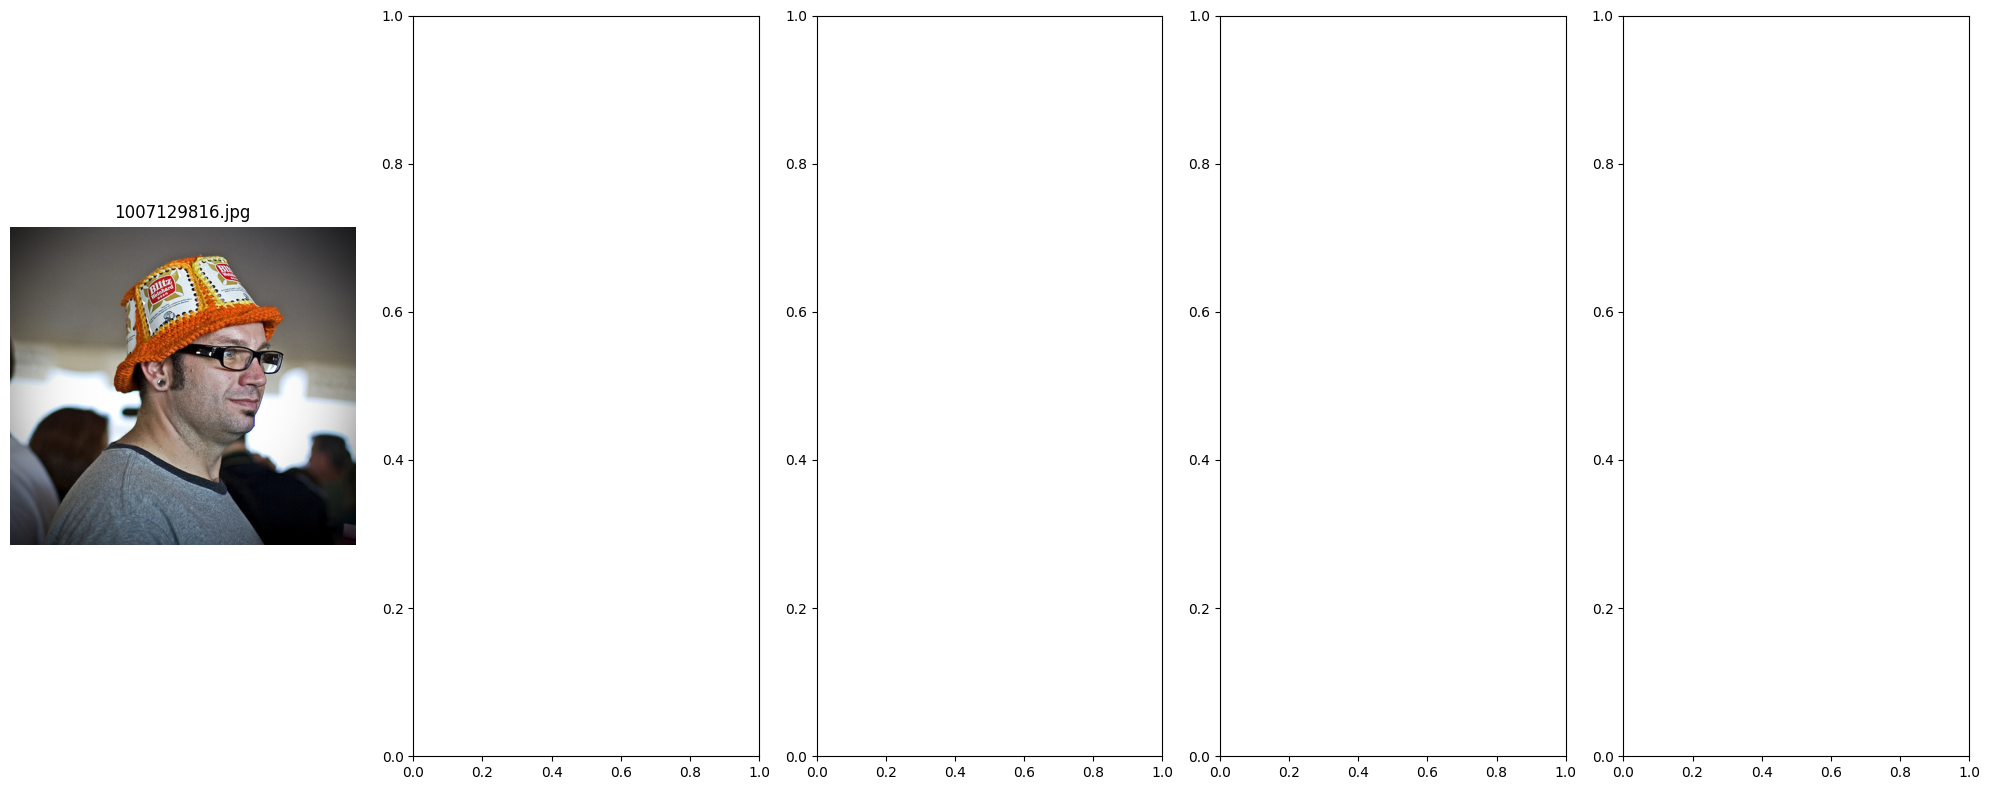

In [25]:
# 主逻辑
def run_sample_case(file_type, file_path=None, dataset_name=None, split=None):
    # 通过工厂函数获取数据加载器
    data_loader = get_data_loader(file_type, file_path=file_path, dataset_name=dataset_name, split=split)
    data = data_loader.load_data()  # 加载数据

    print(data.shape)  # 打印数据的形状
    
    # 先看一张
    i = 0
    # 初始查询
    print(data.iloc[i])
    # !雷 flickr30k 这里, 是个字符串类型的list!!!!!!!
    raw_str = data.iloc[i]["raw"]
    raw_list = json.loads(raw_str)  # 将字符串解析为列表
    query = raw_list[0]  # 获取列表中的第一个元素
    print(f'query: {query}')
    target_image_path = './playground/data/flickr30k-images/' + data.iloc[i]["filename"]  # 获取目标图像路径 - flickr30k这里是 'filename'/ 还有这里图片的库路径也变了哟
    
    # 初次检索
    image_paths, indices = retrieve_topk_images([query], topk=50000, faiss_model=faiss_model, blip_model=dialog_encoder, id2image=id2image, processor=None)

    image_rank = find_index_in_list(target_image_path, image_paths[0])

    # 初始化最大轮次和提前终止条件
    # 初始化参数
    initial_rank = image_rank
    max_rounds = 5
    rank_threshold = 10
    round_number = 0
    accumulated_summary = ""
    previous_questions = [query]
    image_ranks_per_round = []
    
    # 初始化询问
    query_with_feedback = "Initial Query: " + query + accumulated_summary  # 将用户的反馈添加到query中


    # 多轮问询循环
    while round_number < max_rounds:
        round_number += 1
        print(f"Round {round_number}:")
        
        # 选择图片并生成问题
        top_images_path = image_paths[0][:40]
        random_selection_path = random.sample(top_images_path, 5)
        base64_image_top = [encode_image(image_path) for image_path in random_selection_path]
        
        # 生成问题
        question = generate_valid_question(base64_image_top, system_prompt, previous_questions)
        previous_questions.append(question)
        
        # 生成目标图像的回答
        base64_target_image = encode_image(target_image_path)
        answer_of_question = answer(question, base64_target_image)
        
        print(f'new -> question: {question}, answer_of_question: {answer_of_question}')
        
        
        # 更新累积总结，每轮都累加之前的问答
        accumulated_summary = f" Question: {question} Answer: {answer_of_question}"
        
        # 更新 query，每轮 query 都包含初始描述和累积总结
        query_with_feedback += accumulated_summary  # 将用户的反馈添加到 query 中
        print(f'query_with_feedback: {query_with_feedback}, ')
        
        # 基于累积的总结生成新的描述，并重新检索
        # summary_of_question_and_option = summary(query_with_feedback, question, answer_of_question)
        
        # 直接使用 query_with_feedback 进行检索，不生成 summary_of_question_and_option
        image_paths_new, indices = retrieve_topk_images([query_with_feedback], topk=50000, faiss_model=faiss_model, blip_model=dialog_encoder, id2image=id2image, processor=None)
        
        # 计算新的排名
        image_rank_new = find_index_in_list(target_image_path, image_paths_new[0])
        image_ranks_per_round.append((image_rank_new, image_paths_new[0]))  # 记录每轮的排名和对应的图片路径
        
        # 输出本轮结果
        print(f"Old Rank: {image_rank}, New Rank: {image_rank_new}")
        
        # 判断是否达到早停条件：目标图像排名小于10
        if image_rank_new < rank_threshold:
            print(f"Image rank ({image_rank_new}) is below the threshold ({rank_threshold}). Ending early.")

            break
        
        # 更新查询结果，继续下一轮
        image_paths = image_paths_new
        image_rank = image_rank_new

    # 查找最佳排名
    best_rank, best_image_paths = min(image_ranks_per_round, key=lambda x: x[0])  # 找到最小的rank和对应的图片路径
    best_image_path = best_image_paths[0]  # 选择路径中的第一个图片路径

    # 输出最终结果
    if best_rank < initial_rank:
        print(f"Final Best Rank improved from {initial_rank} to {best_rank}, Best Image Path: {best_image_path}")
    else:
        print(f"No significant improvement. Final Best Rank: {best_rank}, Best Image Path: {best_image_path}")
        
    show_image(image_paths[0][:best_rank+1], sentence=None)


# 示例调用
# 加载 CSV 数据集的情况
#这个数据集的 query列，叫做option， 比如 - 'trailer tractor truck in parking lot with natural greenery'
# run_sample_case(file_type="csv", file_path="/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/group_20-50.csv")

#flickr30k数据集的 query列，叫做caption, 是个list, 比如：[ "Two young guys with shaggy hair look at their hands while hanging out in the yard.", "Two young, White males are outside near many bushes.", "Two men in green shirts are standing in a yard.", "A man in a blue shirt standing in a garden.", "Two friends enjoy time spent together." ]
run_sample_case(file_type="csv", file_path="/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/flickr30k/flickr_annotations_filtered_30k.csv")

# # 加载 Hugging Face 数据集的情况
# run_sample_case(file_type="huggingface", dataset_name="nlphuji/flickr30k", split="test")


## 多轮代码实现

In [26]:
#用于多轮代码的数据集

# 1. 定义数据集路径列表
folder_path = '/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/flickr30k/'
file_name_list = [
    'flickr_annotations_filtered_30k.csv',
]

In [2]:
# 封装的 CSV 初始化函数
def init_csv_file(output_file):
    fieldnames = [
        'file_name', 
        'query_number', 
        'initial_rank', 
        'best_rank', 
        'rounds', 
        'image_ranks_per_round', 
        'top_10_hits_before', 
        'top_10_hits_after',
        'queries_feedback',  # 用于记录所有轮次的反馈信息
        'average_rank'
    ]
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    return fieldnames


In [28]:
# 封装的保存结果到 CSV 文件的函数
def save_results_to_csv(output_file, fieldnames, file_name, query_number, initial_rank, best_rank, rounds, image_ranks_per_round, top_10_hits_before, top_10_hits_after, queries_feedback):
    
    # 计算平均排名
    ranks = list(map(int, image_ranks_per_round.split(',')))  # 将字符串转为整数列表
    average_rank = sum(ranks) / len(ranks) if ranks else 0  # 计算平均值，避免空列表导致除以零错误
    
    with open(output_file, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({
            'file_name': file_name,
            'query_number': query_number,
            'initial_rank': initial_rank,
            'best_rank': best_rank,
            'rounds': rounds,
            'image_ranks_per_round': image_ranks_per_round,
            'top_10_hits_before': top_10_hits_before,
            'top_10_hits_after': top_10_hits_after,
            'queries_feedback': queries_feedback,  # 存储所有轮次的反馈信息
            'average_rank': average_rank  # 添加新的列
        })

In [29]:
# 读csv文件的 - 暂时不用了

def read_csv(file_path):
    # 使用 pandas 读取 CSV 文件
    data = pd.read_csv(file_path)
    return data

In [1]:
import csv
from tqdm import tqdm

query_question = []

# 设定多轮询问的参数
max_rounds = 5
rank_threshold = 10  # 提前终止条件

# 新增 Top-10 Recall 相关变量
top_10_hits_before = 0  # 记录在 Top-10 内命中的次数（初次搜索）
top_10_hits_after = 0  # 记录在 Top-10 内命中的次数（多轮问询后）
total_queries_accumulated = 0  # 用于累计所有数据集的查询数量

# 定义输出文件路径
output_file = 'multi-round-result_Blip_FT_flickr30k_without_summary.csv'

# 初始化 CSV 文件
fieldnames = init_csv_file(output_file)

'''
# 设定要处理的行范围
start_row = 240
end_row = 400
'''

# 4. 循环遍历每个数据集
for file_name in file_name_list:
    file_path = folder_path + file_name
    csv_data = read_csv(file_path)  # 读取当前数据集

    total_queries = len(csv_data)  # 测试的总样本数
    total_queries_accumulated += total_queries  # 累积查询数量
    '''
    # 确保索引不超过数据集的总长度
    start_row = max(0, start_row)
    end_row = min(total_queries, end_row)
    '''
    # 数据集的局部统计变量
    top_10_hits_before_dataset = 0  # 记录该数据集中 Top-10 内命中的次数（初次搜索）
    top_10_hits_after_dataset = 0  # 记录该数据集中 Top-10 内命中的次数（多轮问询后）
    
    print(f"处理数据集: {file_name}, 总共 {total_queries} 个查询")  # 打印数据集信息

    # 开始全数据集循环处理
    for i in tqdm(range(total_queries)):
        # !雷 flickr30k 这里, 是个字符串类型的list!!!!!!!
        raw_str = csv_data.iloc[i]["raw"]
        raw_list = json.loads(raw_str)  # 将字符串解析为列表
        query = raw_list[0]  # 获取列表中的第一个元素
        
        target_image_path = './playground/data/flickr30k-images/' + csv_data["filename"][i]  # 获取目标图像路径 flickr30k: "filename"
        
        # 记录每轮排名
        image_ranks_per_round = []
        queries_feedback = []  # 用于存储每一轮的query、问题和答案
        
        # 初步搜索
        image_paths, indices = retrieve_topk_images([query],
                                                    topk=50000,
                                                    faiss_model=faiss_model,
                                                    blip_model=dialog_encoder,
                                                    id2image=id2image,
                                                    processor=None)
        image_rank = find_index_in_list(target_image_path, image_paths[0])
        
        # 判断目标图像是否在 Top-10 内，若在则计数
        if image_rank < 10:
            top_10_hits_before += 1
            top_10_hits_before_dataset += 1

        # 记录初始排名
        initial_rank = image_rank
        
        # 初始化累积问答和query反馈
        accumulated_summary = ""
        previous_questions = [query]  # 初始化问题列表
        query_with_feedback = "Initial Query: " + query + accumulated_summary  # 将用户的反馈添加到query中
        
        round_number = 0
        
        # 进入多轮问询循环
        while round_number < max_rounds:
            round_number += 1
            # 随机选择前40张图片中的5张
            top_images_path = image_paths[0][:40]
            random_selection_path = random.sample(top_images_path, 5)
            base64_image_top = [encode_image(image_path) for image_path in random_selection_path]
            
            # 生成问题
            question = generate_valid_question(base64_image_top, system_prompt, previous_questions)
            
            # 检查问题是否生成成功
            if question is None:
                print(f"Failed to generate a valid question for image {i+1}, skipping this sample.")
                continue
            
            query_question.append([query_with_feedback, question])
            previous_questions.append(question)  # 将问题加入previous_questions，避免重复提问
            
            # 生成目标图像的回答
            base64_target_image = encode_image(target_image_path)
            answer_of_question = answer(question, base64_target_image)
            
            # 累积每轮的问答
            accumulated_summary = f" Question: {question} Answer: {answer_of_question}"
            
            query_with_feedback += accumulated_summary  # 将用户的反馈添加到 query 中
            
            # 做 summary
            # summary_of_question_and_option = summary(query_with_feedback, question, answer_of_question)
            
            # 使用 query_with_feedback 进行检索
            image_paths_new, indices = retrieve_topk_images([query_with_feedback],
                                                            topk=50000,
                                                            faiss_model=faiss_model,
                                                            blip_model=dialog_encoder,
                                                            id2image=id2image,
                                                            processor=None)
            
            # 计算新的排名并记录
            image_rank_new = find_index_in_list(target_image_path, image_paths_new[0])
            image_ranks_per_round.append(image_rank_new)  # 存储每轮的rank
            
            # 输出本轮结果
            # 打印每轮的新的排名
            # print(f"Round {round_number + 1}: New Rank: {image_rank_new}, Old Rank: {image_rank},")
            
            # 判断是否达到提前终止条件
            if image_rank_new < rank_threshold:
                print(f"Image rank ({image_rank_new}) is below the threshold ({rank_threshold}). Ending early.")
                break  # 达到阈值提前结束多轮问询
            
            # 更新查询结果，准备进入下一轮
            image_paths = image_paths_new
            
        # 记录每一轮的反馈信息
        queries_feedback.append({
            'query_with_feedback': query_with_feedback,
            # 'question': question,
            # 'answer': answer_of_question
        }) 
        # 查找最佳排名
        best_rank = min(image_ranks_per_round)  # 找到最小的rank
            
        # 判断目标图像是否在多轮后检索的 Top-10 内
        if best_rank < 10:
            top_10_hits_after += 1
            top_10_hits_after_dataset += 1

        # 将每一轮的反馈信息和结果存入 CSV 文件
        save_results_to_csv(
            output_file, 
            fieldnames, 
            file_name, 
            i + 1, 
            initial_rank, 
            best_rank, 
            round_number , 
            ','.join(map(str, image_ranks_per_round)), 
            top_10_hits_before_dataset, 
            top_10_hits_after_dataset,
            queries_feedback  # 新增的查询和反馈信息
        )
        print(f"第 {i+1} 张图片的测试结果已保存到 CSV。")
        
    # 计算并输出每个数据集的 Top-10 召回率
    top_10_recall_rate_before_dataset = top_10_hits_before_dataset / total_queries
    top_10_recall_rate_after_dataset = top_10_hits_after_dataset / total_queries
    print(f'Dataset: {file_name} - Top-10 hits before multi-round: {top_10_hits_before_dataset}, total_queries: {total_queries}')
    print(f"Dataset: {file_name} - Top-10 Recall Rate before multi-round: {top_10_recall_rate_before_dataset * 100:.4f}%")
    print(f'Dataset: {file_name} - Top-10 hits after multi-round: {top_10_hits_after_dataset}, total_queries: {total_queries}')
    print(f"Dataset: {file_name} - Top-10 Recall Rate after multi-round: {top_10_recall_rate_after_dataset * 100:.4f}%")
    print('---------------------------------------')
    
# 全局统计
top_10_recall_rate_before = top_10_hits_before / total_queries_accumulated
top_10_recall_rate_after = top_10_hits_after / total_queries_accumulated
print(f'top_10_hits before multi-round: {top_10_hits_before}, total_queries_accumulated: {total_queries_accumulated}')
print(f"Top-10 Recall Rate before multi-round: {top_10_recall_rate_before * 100:.4f}%")
print(f'top_10_hits after multi-round: {top_10_hits_after}, total_queries_accumulated: {total_queries_accumulated}')
print(f"Top-10 Recall Rate after multi-round: {top_10_recall_rate_after * 100:.4f}%")

# 最终输出所有结果
print("全数据集检索完成。")


NameError: name 'init_csv_file' is not defined